
# Purchase Prediction — End-to-End Analysis (No Pipelines)

This notebook performs a full mini-analysis of a sample dataset and predicts whether a purchase was made — **without using scikit-learn Pipelines**.  
We go step by step:
1. Load data
2. Explore & visualize
3. Clean & preprocess (manual imputation, encoding, scaling)
4. Train/test split
5. Train a model (RandomForest)
6. Evaluate
7. Predict

> **Note:** All charts use **matplotlib** only, each in its own figure, and no explicit colors or styles are set.


## 1. Imports and Data Setup

In [13]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

# Ensure plots display inline (for Jupyter)
%matplotlib inline

# Construct the sample dataset
df = pd.DataFrame({
    'Age': [25, 30, None, 45, 35],
    'Income': [50000, 60000, 55000, None, 58000],
    'Gender': ['Male', 'Female', 'Female', None, 'Male'],
    'Purchased': [1, 0, 1, 0, 1]
})

df


,Age,Income,Gender,Purchased
0,25.0,50000.0,Male,1
1,30.0,60000.0,Female,0
2,NaN,55000.0,Female,1
3,45.0,NaN,None,0
4,35.0,58000.0,Male,1


## 2. Exploratory Data Analysis

In [12]:

# Shape, dtypes, head/tail
print("Shape:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isna().sum())

df.describe()


Shape: (5, 4)

Data types:
 Age          float64
Income       float64
Gender        object
Purchased      int64
dtype: object

Missing values:
 Age          1
Income       1
Gender       1
Purchased    0
dtype: int64


,Age,Income,Purchased
count,4.000000,4.00000,5.000000
mean,33.750000,55750.00000,0.600000
std,8.539126,4349.32945,0.547723
min,25.000000,50000.00000,0.000000
25%,28.750000,53750.00000,0.000000
50%,32.500000,56500.00000,1.000000
75%,37.500000,58500.00000,1.000000
max,45.000000,60000.00000,1.000000


### 2.1 Visualizations

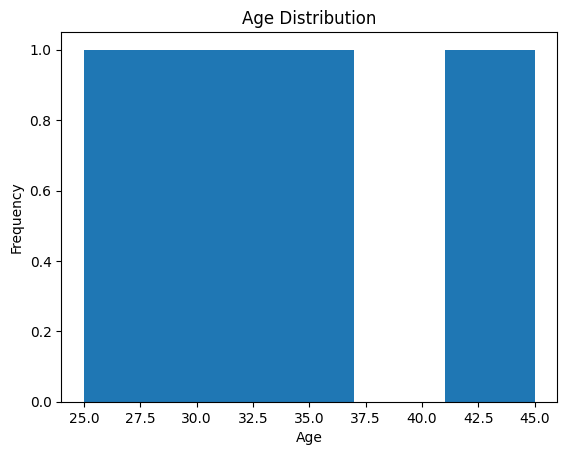

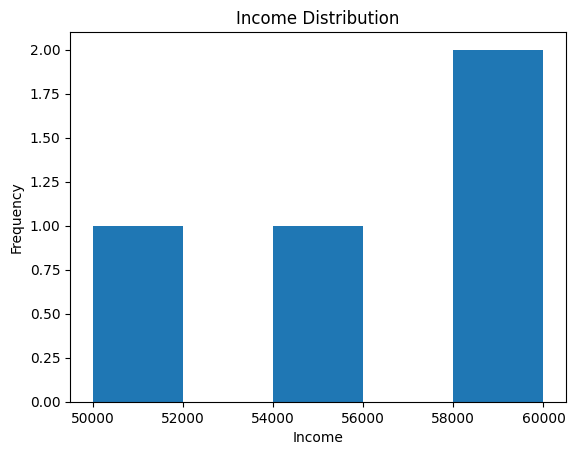

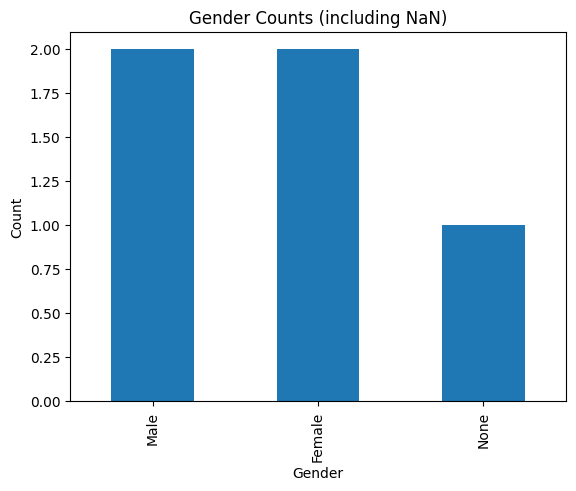

In [3]:

# Histogram for Age
plt.figure()
df['Age'].plot(kind='hist', bins=5, title='Age Distribution')
plt.xlabel('Age')
plt.show()

# Histogram for Income
plt.figure()
df['Income'].plot(kind='hist', bins=5, title='Income Distribution')
plt.xlabel('Income')
plt.show()

# Bar chart for Gender counts
plt.figure()
df['Gender'].value_counts(dropna=False).plot(kind='bar', title='Gender Counts (including NaN)')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


## 3. Data Cleaning & Preprocessing (No Pipelines)

In [14]:

# Separate features and target
X = df.drop(columns=['Purchased']).copy()
y = df['Purchased'].copy()

# Split early to avoid leakage (fit imputers/scalers only on train)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Identify columns by type
numeric_features = ['Age', 'Income']
categorical_features = ['Gender']

# --- Numeric imputation (mean) ---
num_imputer = SimpleImputer(strategy='mean')
X_train_num = pd.DataFrame(
    num_imputer.fit_transform(X_train[numeric_features]),
    columns=numeric_features,
    index=X_train.index
)
X_test_num = pd.DataFrame(
    num_imputer.transform(X_test[numeric_features]),
    columns=numeric_features,
    index=X_test.index
)

# --- Categorical imputation (most frequent) ---
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train_cat = pd.DataFrame(
    cat_imputer.fit_transform(X_train[categorical_features]),
    columns=categorical_features,
    index=X_train.index
)
X_test_cat = pd.DataFrame(
    cat_imputer.transform(X_test[categorical_features]),
    columns=categorical_features,
    index=X_test.index
)

# Instantiate encoder
ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

# Fit only on training data (VERY IMPORTANT)
X_train_cat_enc = ohe.fit_transform(X_train_cat)

# Transform test data
X_test_cat_enc = ohe.transform(X_test_cat)

# Get feature names
ohe_columns = ohe.get_feature_names_out(categorical_features)

# Convert to DataFrames
X_train_cat_enc = pd.DataFrame(X_train_cat_enc, columns=ohe_columns, index=X_train.index)
X_test_cat_enc = pd.DataFrame(X_test_cat_enc, columns=ohe_columns, index=X_test.index)

# --- Scale numeric columns (fit on train only) ---
scaler = StandardScaler()
X_train_num_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_num),
    columns=numeric_features,
    index=X_train.index
)
X_test_num_scaled = pd.DataFrame(
    scaler.transform(X_test_num),
    columns=numeric_features,
    index=X_test.index
)

# --- Combine numeric and categorical ---
X_train_final = pd.concat([X_train_num_scaled, X_train_cat_enc], axis=1)
X_test_final = pd.concat([X_test_num_scaled, X_test_cat_enc], axis=1)

print("Train features:\n", X_train_final.head(), "\n")
print("Test features:\n", X_test_final.head())


Train features:
         Age    Income  Gender_Male  Gender_None
3  1.224745  0.000000          0.0          1.0
2  0.000000 -1.224745          0.0          0.0
4 -1.224745  1.224745          1.0          0.0 

Test features:
         Age    Income  Gender_Male  Gender_None
0 -3.674235 -5.307228          1.0          0.0
1 -2.449490  2.857738          0.0          0.0


## 4. Model Training (RandomForest)

In [6]:

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_final, y_train)

print("Model trained.")


Model trained.


## 5. Evaluation

In [8]:

# Predictions and probabilities
y_pred = clf.predict(X_test_final)
y_proba = clf.predict_proba(X_test_final)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.5

Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         1
           1     0.5000    1.0000    0.6667         1

    accuracy                         0.5000         2
   macro avg     0.2500    0.5000    0.3333         2
weighted avg     0.2500    0.5000    0.3333         2



C:\Users\Saksham Loona\anaconda3\envs\Saksham\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Saksham Loona\anaconda3\envs\Saksham\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Saksham Loona\anaconda3\envs\Saksham\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

### 5.1 Feature Importance

Age            0.429104
Income         0.384328
Gender_Male    0.186567
dtype: float64


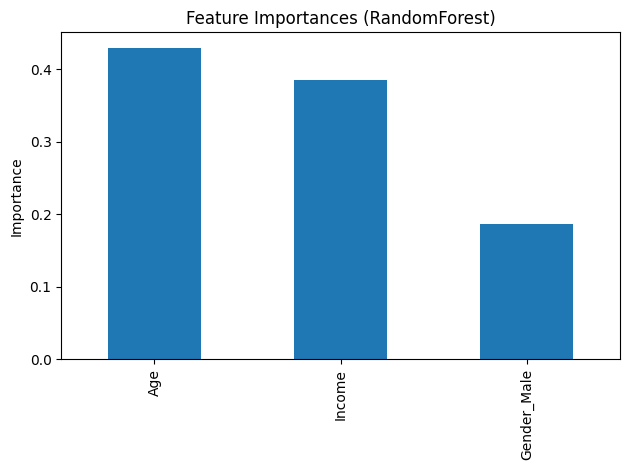

In [9]:

importances = clf.feature_importances_
feat_names = X_train_final.columns

fi = pd.Series(importances, index=feat_names).sort_values(ascending=False)
print(fi)

plt.figure()
fi.plot(kind='bar', title='Feature Importances (RandomForest)')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


## 6. Predict on New/Unseen Data

In [10]:

# Example new records to predict
new_data = pd.DataFrame({
    'Age': [28, 52],
    'Income': [52000, 75000],
    'Gender': ['Female', 'Male']
})

# --- Apply the SAME preprocessing steps (imputation, encoding, scaling) ---
# 1) Numeric impute + scale using train-fitted transformers
new_num = pd.DataFrame(num_imputer.transform(new_data[numeric_features]), columns=numeric_features)
new_num_scaled = pd.DataFrame(scaler.transform(new_num), columns=numeric_features)

# 2) Categorical impute + encode using train-fitted
new_cat = pd.DataFrame(cat_imputer.transform(new_data[categorical_features]), columns=categorical_features)
new_cat_enc = pd.get_dummies(new_cat, drop_first=True)

# Align to training columns
new_cat_enc = new_cat_enc.reindex(columns=X_train_cat_enc.columns, fill_value=0)

# 3) Combine
new_final = pd.concat([new_num_scaled, new_cat_enc], axis=1)

# Predict
new_pred = clf.predict(new_final)
new_proba = clf.predict_proba(new_final)[:, 1]

pred_df = new_data.copy()
pred_df['Purchase_Pred'] = new_pred
pred_df['Purchase_Probability'] = new_proba

pred_df


,Age,Income,Gender,Purchase_Pred,Purchase_Probability
0,28,52000,Female,1,0.80
1,52,75000,Male,1,0.55



## 7. Notes
- This is a toy dataset (5 rows). Metrics will be unstable and mainly illustrative.
- We split before fitting imputers/scalers to avoid data leakage.
- We did all preprocessing manually (no `Pipeline`, no `ColumnTransformer`).
- If you add more categorical columns, repeat the same impute → get_dummies → align steps.
